In [2]:
import sys
import scipy.io
import scipy.signal as sig
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import os

### Load the CinC training dataset

In [2]:
# Start by loading the data

training_path = "CinC2017Data/training2017/training2017/"
answers_path = "CinC2017Data/REFERENCE-v3.csv"

dataset = pd.read_csv(answers_path, header=None, names=["class"], index_col=0)
dataset["data"] = None

print(dataset.head())

for root, dirs, files in os.walk(training_path):
    for name in files:
        try:
            name, ext = name.split(".")
        except ValueError:
            print("error, scipping file")
            continue
        if ext == "mat":
            mat_data = scipy.io.loadmat(os.path.join(root, name+"."+ext))
            dataset.loc[name]["data"] = mat_data["val"]
            print(f"Adding {name}\r", end="")
            
print(dataset.head())
pk_path = "CinC2017Data/database.pk"
dataset.to_pickle(pk_path)

       class  data
A00001     N  None
A00002     N  None
A00003     N  None
A00004     A  None
A00005     A  None


KeyboardInterrupt: 

In [15]:
dataset = pd.read_pickle("CinC2017Data/database.pk")

In [4]:
def adaptive_gain_norm(x, w):
    x_mean_sub = np.pad(x - x.mean(), int((w-1)/2), "reflect")
    window = np.ones(w)
    sigma_square = np.convolve(x_mean_sub**2, window, mode="valid")/w
    gain = 1/np.sqrt(sigma_square)
    
    return x * gain

In [16]:
dataset["length"] = dataset["data"].map(lambda arr: arr.shape[-1])
dataset["data"] = dataset["data"].map(lambda d: d[0])

In [17]:
# select only the 30s length records
dataset = dataset[dataset["length"] == 9000]

In [18]:
dataset["data"] = dataset["data"].map(lambda d: adaptive_gain_norm(d, 501))

NameError: name 'adaptive_gain_norm' is not defined

### Load the SAFER dataset

In [3]:
from enum import Enum

class DiagEnum(Enum):
    AF = 1
    CannotExcludePathology = 2
    NoAF = 3
    PoorQuality = 4
    ScreeningFailure = 5
    Undecided = 6
    ReviewersDisagree = -1

feas2_path = r"D:\2022_23_DSiromani\Feas2"

feas2_pt_data = pd.read_csv(os.path.join(feas2_path, "pt_data_anon.csv"))
feas2_ecg_data = pd.read_pickle(os.path.join(feas2_path, r"ECGs\filtered_dataframe.pk"))

print(feas2_ecg_data.head())

   ptID   age         ptDiag          ptDiagRev1     ptDiagRev2  \
0     1  79.0  DiagEnum.NoAF  DiagEnum.Undecided  DiagEnum.NoAF   
1     1  79.0  DiagEnum.NoAF  DiagEnum.Undecided  DiagEnum.NoAF   
2     1  79.0  DiagEnum.NoAF  DiagEnum.Undecided  DiagEnum.NoAF   
3     1  79.0  DiagEnum.NoAF  DiagEnum.Undecided  DiagEnum.NoAF   
4     1  79.0  DiagEnum.NoAF  DiagEnum.Undecided  DiagEnum.NoAF   

           ptDiagRev3  cardRev            measDiag        measDiagRev1  \
0  DiagEnum.Undecided        1  DiagEnum.Undecided  DiagEnum.Undecided   
1  DiagEnum.Undecided        1  DiagEnum.Undecided  DiagEnum.Undecided   
2  DiagEnum.Undecided        1  DiagEnum.Undecided  DiagEnum.Undecided   
3  DiagEnum.Undecided        1  DiagEnum.Undecided  DiagEnum.Undecided   
4  DiagEnum.Undecided        1  DiagEnum.Undecided  DiagEnum.Undecided   

         measDiagRev2  ...  poss_AF_tag not_tagged  not_tagged_ign_wide_qrs  \
0  DiagEnum.Undecided  ...            0          1                       

In [57]:
# Resample to 300Hz
feas2_ecg_data["data"] = feas2_ecg_data["data"].map(lambda x: scipy.signal.resample(x, 9000))

In [46]:
from scipy import signal
sos = signal.butter(3, [0.67, 30], 'band', fs=500, output='sos')

def filter_and_norm(x, sos):

    x_filt = signal.sosfiltfilt(sos, x, padlen=150)
    return (x_filt - x_filt.mean())/x_filt.std()

feas2_ecg_data["data"] = feas2_ecg_data["data"].map(lambda x: filter_and_norm(x, sos))

### Initialise the model

In [ ]:
!pip install torch

In [4]:
import torch.nn as nn
import torch

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [6]:
# Check cuda
print(torch.cuda.is_available())

True


In [19]:
# Now define a model

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_section1 = nn.Sequential(
            nn.Conv1d(1, 128, 16, stride=4),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(128)
        )

        self.conv_section2 = nn.Sequential(
            nn.Conv1d(128, 256, 11, stride=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(256)
        )

        self.conv_section3 = nn.Sequential(
            nn.Conv1d(256, 256, 3),
            nn.ReLU(),
            nn.Conv1d(256, 256, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(256)
        )

        self.conv_section4 = nn.Sequential(
            nn.Conv1d(256, 128, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(128)
        )

        self.conv_section5 = nn.Sequential(
            nn.Conv1d(128, 64, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(64)
        )

        self.conv_section6 = nn.Sequential(
            nn.Conv1d(64, 32, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(32)
        )

        self.lstm_n_hidden = 32
        self.lstm = nn.LSTM(input_size=32, hidden_size=32, bidirectional=True, batch_first=True)

        # self.dense1 = nn.Linear(352, 128)
        self.dense2 = nn.Linear(960, 256)
        self.dense3 = nn.Linear(256, 2)

        self.activation = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=-1)

        self.dropout = nn.Dropout()

    def init_lstm_hidden(self, batch_size, device):
        # This resets the LSTM hidden state after each batch
        hidden_state = torch.zeros(2, batch_size, self.lstm_n_hidden, device=device)
        cell_state = torch.zeros(2, batch_size, self.lstm_n_hidden, device=device)
        return (hidden_state, cell_state)

    def forward(self, x):

        # [1, 9000]
        x = self.conv_section1(x)

        # [512, 4499]
        x = self.conv_section2(x)

        # [256, 2249]
        x = self.conv_section3(x)

        # [128, 1124]
        x = self.conv_section4(x)

        # [64, 561]
        x = self.conv_section5(x)

        # [32, 280]
        x = self.conv_section6(x)

        # [32, 139]
        x = torch.transpose(x, 1, 2)

        x, _ = self.lstm(x, self.init_lstm_hidden(x.shape[0], x.device))
        x = torch.flatten(x, 1, -1)

        # [1024]
        x = self.dense2(x)
        x = self.activation(x)
        x = self.dropout(x)

        # [128]
        x = self.dense3(x)
        x = self.logsoftmax(x)

        # [4]
        return x

In [10]:
# Onehot encoding
from torch.utils.data import Dataset, DataLoader

def generate_onehot(c):
    if c == "N":
        return np.array([1, 0, 0, 0])
    if c == "O":
        return np.array([0, 1, 0, 0])
    if c == "A":
        return np.array([0, 0, 1, 0])
    if c == "~":
        return np.array([0, 0, 0, 1])

def generate_index(c):
    if c == "N":
        return 0
    if c == "O":
        return 0
    if c == "A":
        return 0
    if c == "~":
        return 1

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dataset):
        'Initialization'
        self.dataset = dataset

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataset.index)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.dataset.iloc[index]

        X = row["data"]
        y = row["class_index"]

        return X, y

In [20]:
# dataset["onehot"] = dataset["class"].map(generate_onehot)
dataset["class_index"] = dataset["class"].map(generate_index)

In [16]:
# For CinC Data
train_dataset, test_dataset = train_test_split(dataset, test_size=0.15, stratify=dataset["class_index"])

torch_dataset_train = Dataset(train_dataset)
torch_dataset_test = Dataset(test_dataset)

train_dataloader = DataLoader(torch_dataset_train, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(torch_dataset_test, batch_size=32, shuffle=True, pin_memory=True)

num_batches = len(train_dataloader)
num_test_batches = len(test_dataloader)
class_counts = torch.tensor(dataset["class_index"].value_counts().values.astype(np.float32))

In [47]:
# For SAFER data
# print(feas2_ecg_data.head())

# dataset["onehot"] = dataset["class"].map(generate_onehot)
feas2_ecg_data["class_index"] = feas2_ecg_data["measDiag"].map(lambda x: int(x == DiagEnum.PoorQuality))

train_patients, test_patients = train_test_split(feas2_pt_data, test_size=0.15)

train_ecgs = feas2_ecg_data[feas2_ecg_data["ptID"].isin(train_patients['ptID'])]
test_ecgs = feas2_ecg_data[feas2_ecg_data["ptID"].isin(test_patients['ptID'])]

# TODO: stratify (at least approximately to ensure similar amounts of noisy and non-noisy samples)
print(train_ecgs["class_index"].value_counts())
print(test_ecgs["class_index"].value_counts())

torch_dataset_train = Dataset(train_ecgs)
torch_dataset_test = Dataset(test_ecgs)

train_dataloader = DataLoader(torch_dataset_train, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(torch_dataset_test, batch_size=32, shuffle=True, pin_memory=True)

num_batches = len(train_dataloader)
num_test_batches = len(test_dataloader)
class_counts = torch.tensor(train_ecgs["class_index"].value_counts().values.astype(np.float32))

0    19221
1      405
Name: class_index, dtype: int64
0    3573
1      60
Name: class_index, dtype: int64


In [48]:
if torch.cuda.is_available():
    print("Using Cuda")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using Cuda


In [49]:
num_epochs = 10
model = CNN().to(device)

# Use weightings to handle class imbalance

class_weights = torch.nn.functional.normalize(1.0/class_counts, dim=0)
loss_func = torch.nn.NLLLoss(class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [50]:
import copy
model = model.to(device)

def train(model):
    best_test_loss = 100
    best_model = copy.deepcopy(model).cpu()

    for epoch in range(num_epochs):
        total_loss = 0
        print(f"starting epoch {epoch} ...")
        # Train
        model.train()
        for i, (signals, labels) in enumerate(train_dataloader):
            signals = torch.unsqueeze(signals.to(device), 1).float()
            # fft = torch.abs(torch.fft.fft(signals))
            # signals = torch.cat([signals, fft], dim=1)
            labels = labels.type(torch.LongTensor)

            optimizer.zero_grad()
            output = model(signals).to("cpu")
            loss = loss_func(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += float(loss)

        print(f"Epoch {epoch} finished with average loss {total_loss/num_batches}")
        print("Testing ...")
        # Test
        test_loss = 0
        with torch.no_grad():
            model.eval()
            for i, (signals, labels) in enumerate(test_dataloader):
                signals = torch.unsqueeze(signals.to(device), 1).float()
                # fft = torch.abs(torch.fft.fft(signals))
                # signals = torch.cat([signals, fft], dim=1)
                labels = labels.type(torch.LongTensor)

                output = model(signals).to("cpu")
                loss = loss_func(output, labels)
                test_loss += float(loss)

        print(f"Average test loss: {test_loss/num_test_batches}")

        if test_loss/num_test_batches < best_test_loss:
            best_model = copy.deepcopy(model).cpu()
            best_test_loss = test_loss/num_test_batches

    return best_model

model = train(model).to(device)

starting epoch 0 ...
Epoch 0 finished with average loss 0.38300335732461577
Testing ...
Average test loss: 0.3217390753459512
starting epoch 1 ...
Epoch 1 finished with average loss 0.3032021971134293
Testing ...
Average test loss: 0.34361671238091956
starting epoch 2 ...
Epoch 2 finished with average loss 0.282306558425244
Testing ...
Average test loss: 0.30237826355324504
starting epoch 3 ...
Epoch 3 finished with average loss 0.25978425128160937
Testing ...
Average test loss: 0.3109416902195989
starting epoch 4 ...
Epoch 4 finished with average loss 0.23922597160653883
Testing ...
Average test loss: 0.31300774749303073
starting epoch 5 ...
Epoch 5 finished with average loss 0.23731736462648217
Testing ...
Average test loss: 0.2900089487523298
starting epoch 6 ...
Epoch 6 finished with average loss 0.20906998018100129
Testing ...
Average test loss: 0.33495280419459994
starting epoch 7 ...
Epoch 7 finished with average loss 0.2001623526603857
Testing ...
Average test loss: 0.448464946

In [23]:
model = CNN().to(device)
model.load_state_dict(torch.load("TrainedModels/CNN_AlexNet_LSTM_Bidirectional_2Class_norm.pt", map_location=device))

<All keys matched successfully>

In [51]:
false_positives = []

def get_conf_mat(model, dataloader):
    model.eval()

    true_labels = []
    predictions = []

    with torch.no_grad():
        for i, (signals, labels) in enumerate(dataloader):
            signals = torch.unsqueeze(signals.to(device), 1).float()
            # fft = torch.abs(torch.fft.fft(signals))
            # signals = torch.cat([signals, fft], dim=1)
            labels = labels.detach().numpy()
            true_labels.append(labels)

            optimizer.zero_grad()
            output = model(signals).detach().to("cpu").numpy()

            prediction = np.argmax(output, axis=-1)
            false_positive = np.logical_and(labels == 0, prediction == 1)
            false_positives.append(signals[false_positive, 0, :].cpu().detach().numpy())

            predictions.append(np.argmax(output, axis=-1))

    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)

    conf_mat = confusion_matrix(true_labels, predictions)
    return conf_mat

conf_mat = get_conf_mat(model, test_dataloader)
false_positives = np.concatenate(false_positives, axis=0)

In [52]:
print(conf_mat)

[[3245  328]
 [  15   45]]


In [53]:
#ConfusionMatrixDisplay.from_predictions(true_labels, predictions, display_labels=["sufficint quality", "insufficient quality"], cmap="inferno")

# Same as the below function (as described in CinC)
def F1_ind(conf_mat, ind):
    return (2 * conf_mat[ind, ind])/(np.sum(conf_mat[ind]) + np.sum(conf_mat[:, ind]))

"""
def bin_F1_score(conf_mat, ind):
    return conf_mat[ind, ind]/(conf_mat[ind, ind] + 0.5 * (conf_mat[0, 1] + conf_mat[1, 0]))

print(f"Normal F1: {bin_F1_score(conf_mat, 0)}")
print(f"Noisy F1: {bin_F1_score(conf_mat, 1)}")
"""

print(f"Sensitivity: {conf_mat[1, 1]/np.sum(conf_mat[1])}")
print(f"Specificity: {conf_mat[0, 0]/np.sum(conf_mat[0])}")

print(f"Normal F1: {F1_ind(conf_mat, 0)}")
print(f"Noisy F1: {F1_ind(conf_mat, 1)}")

Sensitivity: 0.75
Specificity: 0.9082003918275958
Normal F1: 0.9498024293867994
Noisy F1: 0.20785219399538107


In [43]:
index = 10
print(false_positives.shape)

fig = go.Figure(go.Scatter(y=false_positives[index]))
fig.show()

(639, 9000)


In [24]:
# Save a model
torch.save(model.state_dict(), "TrainedModels/CNN_AlexNet_LSTM_Bidirectional_2Class_adaptive_norm.pt")

In [32]:
# Garbage collection - in case of CUDA out of memory error
import gc
model = None
signals = None
labels = None
gc.collect() # Python thing
torch.cuda.empty_cache()

### Perform cross validation

In [33]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

conf_mats = []
fps = []

for i, (train_ind, test_ind) in enumerate(kf.split(dataset)):
    print(f"==========  s p l i t    {i} ========== ")
    train_dataset = dataset.iloc[train_ind]
    test_dataset = dataset.iloc[test_ind]

    torch_dataset_train = Dataset(train_dataset)
    torch_dataset_test = Dataset(test_dataset)

    train_dataloader = DataLoader(torch_dataset_train, batch_size=32, shuffle=True, pin_memory=True)
    test_dataloader = DataLoader(torch_dataset_test, batch_size=32, shuffle=True, pin_memory=True)

    model = CNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    num_batches = len(train_dataloader)
    num_test_batches = len(test_dataloader)

    model = train(model).to(device)

    false_positives = []
    conf_mat = get_conf_mat(model, test_dataloader)

    fps.append(np.concatenate(false_positives, axis=0))
    conf_mats.append(conf_mat)

==========  s p l i t    0 ========== 
starting epoch 0 ...
Epoch 0 finished with average loss 0.44374833807349207
Testing ...
Average test loss: 0.2719452063504018
starting epoch 1 ...
Epoch 1 finished with average loss 0.22745439141988755
Testing ...
Average test loss: 0.2466386605642344
starting epoch 2 ...
Epoch 2 finished with average loss 0.19194606825709343
Testing ...
Average test loss: 0.20302838155705677
starting epoch 3 ...
Epoch 3 finished with average loss 0.15294746747861307
Testing ...
Average test loss: 0.19430183822681246
starting epoch 4 ...
Epoch 4 finished with average loss 0.15395327792813382
Testing ...
Average test loss: 0.4347597824556655
starting epoch 5 ...
Epoch 5 finished with average loss 0.14175425662348667
Testing ...
Average test loss: 0.21919956411186017
starting epoch 6 ...
Epoch 6 finished with average loss 0.08630828712756435
Testing ...
Average test loss: 0.22770278592054782
starting epoch 7 ...
Epoch 7 finished with average loss 0.07340252437007924

In [34]:
f1_scores_normal = [F1_ind(c, 0) for c in conf_mats]
f1_scores_noisy = [F1_ind(c, 1) for c in conf_mats]

print(f"Mean F1 normal: {np.mean(f1_scores_normal)}")
print(f"Mean F1 noisy: {np.mean(f1_scores_noisy)}")

Mean F1 normal: 0.9754747889718735
Mean F1 noisy: 0.4523286046315291


### Test on the noise stress test database

All the data looks the same when you plot it, so something might be wrong with the data reading process!

In [3]:
# load stress test noise data
import wfdb
import os
import scipy.signal

noise_stress_test_db = "mit-bih-noise-stress-test-database"
stress_test_files = ["118e06", "118e00", "118e_6", "119e06", "119e00", "119e_6"]

labels = []
noise_level = []
samples = []

# Additionally band pass filter
def filter_ecg(x, fs):
    b, a = scipy.signal.butter(3, [0.66, 50], 'band', fs=fs)
    x = scipy.signal.filtfilt(b, a, x, padlen=150)
    x = (x - min(x)) / (max(x) - min(x))
    return x

for file in stress_test_files:
    try:
        print(f"Reading file: {file}")
        data = wfdb.io.rdrecord(os.path.join(noise_stress_test_db, file))
        all_data_v1 = data.p_signal[:,1]
        # Resample to 300Hz
        all_data_v1 = scipy.signal.resample(all_data_v1, int(all_data_v1.shape[0] * 300/data.fs))
        # all_data_v1 = filter_ecg(all_data_v1, data.fs)
        # all_data_v1 = adaptive_gain_norm(all_data_v1, 501)

        sec_len = 300 * 30  # 30s segments
        i = 1
        while i * sec_len < all_data_v1.shape[0]:
            s = all_data_v1[(i-1)*sec_len:i*sec_len]
            samples.append(s)
            noise_level.append(file.split("e")[-1])

            if i * 30 < 300:
                labels.append("N")
            elif (i * 30 - 300) % 240 > 120 or (i * 30 - 300) % 240 == 0:
                labels.append("N")
            elif (i * 30 - 300) % 240 <= 120:
                labels.append("~")

            i += 1

    except ValueError:
        print("error, scipping file")
        continue


nst_df = pd.DataFrame({"data": samples, "class": labels, "noise_level": noise_level})
pk_path = "mit-bih-noise-stress-test-database/database.pk"
nst_df.to_pickle(pk_path)

Reading file: 118e06
Reading file: 118e00
Reading file: 118e_6
Reading file: 119e06
Reading file: 119e00
Reading file: 119e_6


In [32]:
print(nst_df.head())

                                                data class noise_level
0  [0.34261153470767114, 0.41070874853712186, 0.4...     N          06
1  [0.3501227677336947, 0.34211563053515787, 0.33...     N          06
2  [0.35824074419182894, 0.3591817878690705, 0.35...     N          06
3  [0.3541364915568786, 0.3533866490293773, 0.352...     N          06
4  [0.32027075062042265, 0.32501828199285, 0.3310...     N          06


In [33]:
# dataset["onehot"] = dataset["class"].map(generate_onehot)
nst_df["class_index"] = nst_df["class"].map(generate_index)

class NSTDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dataset):
        'Initialization'
        self.dataset = dataset

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataset.index)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.dataset.iloc[index]

        X = row["data"]  # The only dataset and nst dataset difference is in this line!
        y = row["class_index"]

        return X, y

# Normalise the data
nst_df["data"] = (nst_df["data"] - nst_df["data"].map(lambda x: x.mean()))/nst_df["data"].map(lambda x: x.std())

torch_dataset_nst = NSTDataset(nst_df)
nst_dataloader = DataLoader(torch_dataset_nst, batch_size=32, shuffle=True, pin_memory=True)

In [34]:
model.eval()

true_labels = []
predictions = []

false_positives = []
true_negatives = []

with torch.no_grad():
    for i, (signals, labels) in enumerate(nst_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        labels = labels.detach().numpy()
        true_labels.append(labels)

        optimizer.zero_grad()
        output = model(signals).detach().to("cpu").numpy()

        prediction = np.argmax(output, axis=-1)
        false_positive = np.logical_and(labels == 0, prediction == 1)
        false_positives.append(signals[false_positive, 0, :].cpu().detach().numpy())

        true_negative = np.logical_and(labels == 1, prediction == 0)
        true_negatives.append(signals[true_negative, 0, :].cpu().detach().numpy())

        predictions.append(np.argmax(output, axis=-1))

predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)
false_positives = np.concatenate(false_positives, axis=0)
true_negatives = np.concatenate(true_negatives, axis=0)

Normal F1: 0.8502673796791443
Other F1: 0.838150289017341
Average F1 score: 0.8442088343482427


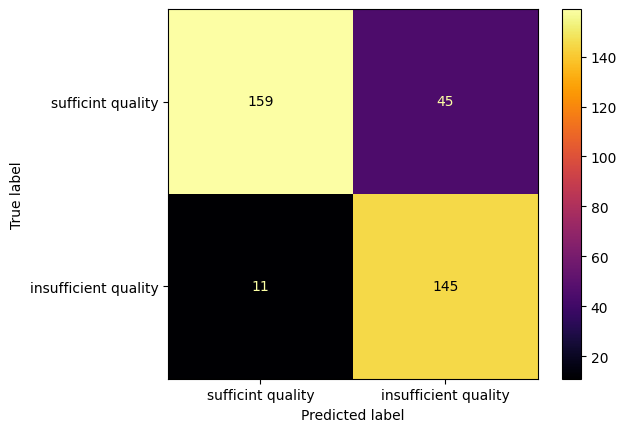

In [35]:
ConfusionMatrixDisplay.from_predictions(true_labels, predictions, display_labels=["sufficint quality", "insufficient quality"], cmap="inferno")

conf_mat = confusion_matrix(true_labels, predictions)

def F1_ind(conf_mat, ind):
    return (2 * conf_mat[ind, ind])/(np.sum(conf_mat[ind]) + np.sum(conf_mat[:, ind]))

print(f"Normal F1: {F1_ind(conf_mat, 0)}")
print(f"Other F1: {F1_ind(conf_mat, 1)}")
# print(f"AF F1: {F1_ind(conf_mat, 2)}")
# print(f"Noisy F1: {F1_ind(conf_mat, 3)}")

print(f"Average F1 score: {sum([F1_ind(conf_mat, i) for i in range(2)])/2}")

In [41]:
index = 40
print(false_positives.shape)

fig = go.Figure(go.Scatter(y=false_positives[index]))
fig.show()

(45, 9000)


In [57]:
index = 15
print(true_negatives.shape)

fig = go.Figure(go.Scatter(y=true_negatives[index]))
fig.show()

(27, 9000)


### Test on SAFER data

In [29]:
false_positives = []
c_mat_safer = get_conf_mat(model, train_dataloader)
print(c_mat_safer)

print(f"Sensitivity: {c_mat_safer[1, 1]/np.sum(c_mat_safer[1])}")
print(f"Specificity: {c_mat_safer[0, 0]/np.sum(c_mat_safer[0])}")

print(f"Normal F1: {F1_ind(c_mat_safer, 0)}")
print(f"Noisy F1: {F1_ind(c_mat_safer, 1)}")

[[10928  8324]
 [   40   361]]
Sensitivity: 0.9002493765586035
Specificity: 0.5676293372117183
Normal F1: 0.7232296492389146
Noisy F1: 0.07946290997138455
